# LDA Topic Modeling


In [2]:
import nltk
import json
import string
import gensim
import matplotlib.pyplot as plt
import requests
import re

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import cluster

# Charger les données

In [7]:
def getId(liste, page, header):
    """
    les id des decisions en rapport avec les universités
    """
    param = "query=universite%20&jurisdiction=cc&jurisdiction=ca&jurisdiction=tj&date_start=2021-01-01&date_end=2024-01-01&page_size=50&page="+str(page)

    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/search?"+param,
                            headers=header)

    if response.status_code == 200:
        data = response.json()
        for decision in data["results"]:
            liste.append(decision["id"])

header = {"accept": "application/json",
          "KeyId": "80f0270f-5e79-4685-abfb-cb2b92e0c24e"}
list_id = list()
page = 0
while page < 13:
    getId(list_id, page, header)
    page = page + 1
print("Nombre de id récupéré: ",len(list_id))

Nombre de id récupéré:  635
['6042501acc3e685be4d966cf', '61e7b7dca41da869de68a273', '652e241092ba0983187683bb', '60dc08b7f6c5197026403e6f', '627b53604d359c057dd01cd2', '634f93f8b5afe5adfff28804', '65701d21604055831871b027', '637f238a3aa45005d42d80c6', '6093acc2ab4025311647a76b', '60c993fe7c5a5b81c05bdfc3', '643f8cf8ad85da04f53a3db4', '615552de31e3e013882fcff9', '620ca2d5c61f23729bcf61e4', '618b9644adc3ef6ccc2a2282', '613876fbf3c12c05124a3fa9', '62e226923de91be2e9f7ea35', '62e226923de91be2e9f7ea33', '6423d8f978684f04f5814390', '63c1099cbf9fd47c90a13d54', '63ff02d3002ac605de15b8a3', '6440d81de704a005d1ed70c1', '6324137b05769e2d4ddbb312', '65093a1ca0f58c05e647ecb3', '607dde47bdd797b53ae6e09c', '634f9616b5afe5adfff28d7f', '62ad6d28552b2c05e5785a32', '6360c5543c369c7f74996db4', '6297037e7c2a1fa9d4442529', '6253cde0bd3db21cbdd94cf4', '62566efc3b20a89542a2c280', '62566efa3b20a89542a2c27e', '63d4ccd792a57405de3316c5', '62bd3fe257b55769b38b766a', '63d0dc4193de8405dea53246', '633fc374e633183e2e

In [29]:
data = list()

def get_text(id):
    """
    Extraire le texte intégrale des décisions 
    """
    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/decision?id="+id, headers=header)

    if response.status_code == 200:
        d = response.json()
        data.append([d["text"]])

for id in list_id:
    get_text(id)
print(data[1:2])



KeyboardInterrupt: 

# Pré-traitement

In [39]:
# Miniscule
data = [[mot.lower()] for mot in data]

# Suppression des ponctuation 
data = ["".join([c for c in list(t) if not (c in list(string.punctuation))]) for t in data]

# Les chiffres
data = [[re.sub(r"[0-9]+", "", c) for c in text] for text in data]

# Tokenisation
data_quote = [word_tokenize(text) for text in data]

# Lemmatisation
lem = WordNetLemmatizer()
data_lm = [[lem.lemmatize(word) for word in t] for t in data_quote]

AttributeError: 'list' object has no attribute 'lower'

In [28]:
# Stopwords
stop_words = stopwords.words("french")
stop_words.extend(["cette", "cour", "mme", "quil", "dun", "dune", "cassation", "euro", "larticle", "demande",
                   "somme", "monsieur", "société", "fait", "jugement", "code", "titre", "travail", "procédure",
                   "être", "civile", "disposition", "contrat", "madame", "cause", "quelle", "sans", "dont", "dappel",
                   "droit", "décision", "date", "non", "peut", "ainsi", "avoir", "droit", "nest", "mois", "septembre",
                   "charge", "octobre", "novembre", "janvier", "conseil", "demandes", "tribunal", "localité",
                   "plus", "alors"])
data_sw = [[word for word in text if word not in stop_words] for text in data_lm]
print(data_sw[1])

['civ', '.', '1', 'cf', '______________________', 'audience', 'publique', '3', 'mar', '2021', 'rejet', 'batut', ',', 'président', 'arrêt', 'n°', '183', 'fs-p', 'pourvoi', 'n°', 'k', '19-22.855', 'r', 'é', 'p', 'u', 'b', 'i', 'q', 'u', 'e', 'f', 'r', 'a', 'ç', 'a', 'i', 'e', '_________________________', 'nom', 'peuple', 'français', '_________________________', 'arrêt', ',', 'première', 'chambre', ',', '3', 'mar', '2021', 'm.', 'h', '...', '...', 'dit', '...', '...', ',', 'domicilié', '[', '...', ']', ')', ',', 'a', 'formé', 'pourvoi', 'n°', 'k', '19-22.855', 'contre', "l'arrêt", 'rendu', '28', 'mai', '2019', "d'appel", 'paris', '(', 'pôle', '1', ',', 'chambre', '1', ')', ',', 'litige', "l'opposant", ':', '1°/', "l'université", '[', '...', ']', ',', 'siège', '[', '...', ']', ')', ',', '2°/', 'abou', 'dhabi', 'education', 'council', '(', 'adec', ')', ',', 'siège', '[', '...', ']', ')', ',', '3°/', 'ministère', 'affaire', 'présidentielles', 'emirats', 'arabes', 'unis', ',', 'pris', 'person

In [30]:

# On remarque beaucoup de lettre à 1 caractère, des suites d'underscores et de chiffres, on les enlève 

data_sw = [[word for word in text if not word.isdigit()] for text in data_sw]
data_sw = [[word for word in text if not "__" in word] for text in data_sw]
data_sw = [[word.replace("'", "") for word in text] for text in data_sw]
data_sw = [[word for word in text if len(word) >= 4] for text in data_sw]

print(data_sw[0])



['audience', 'publique', 'batut', 'président', 'arrêt', 'f-p+b+i', 'pourvoi', '18-18.296', 'peuple', 'français', 'première', 'chambre', 'rendu', 'larrêt', 'suivant', 'statuant', 'pourvoi', 'formé', 'lécole', 'régionale', 'avocats', 'grand', 'siège', 'contre', 'larrêt', 'rendu', 'avril', 'dappel', 'colmar', 'chambre', 'section', 'litige', 'lopposant', 'domiciliée', 'procureur', 'général', 'près', 'dappel', 'colmar', 'domicilié', 'parquet', 'général', 'défendeurs', 'partie', 'intervenante', 'national', 'barreaux', 'domicilié', 'demanderesse', 'invoque', 'lappui', 'pourvoi', 'moyen', 'unique', 'annexé', 'présent', 'arrêt', 'communication', 'faite', 'procureur', 'général', 'laudience', 'publique', 'présentes', 'batut', 'président', 'gall', 'conseiller', 'référendaire', 'rapporteur', 'kamara', 'conseiller', 'doyen', 'randouin', 'greffier', 'chambre', 'rapport', 'gall', 'conseiller', 'référendaire', 'observation', 'célice', 'soltner', 'texidor', 'périer', 'avocat', 'lécole', 'régionale', 'av

# Utilisation de Gensim 

In [24]:
dic = Dictionary(data_sw)
print(dic)
# Bag of word 
data_bow = [dic.doc2bow(text) for text in data_sw]


Dictionary<40290 unique tokens: ['12-1', '13-1', '18-18.296', '2005/36/ce', '5bis']...>


In [25]:
# Technique LDA
lda = LdaModel(corpus=data_bow, id2word=dic,num_topics=15)
topic = lda.print_topics(num_words=20)
print(topic)

doc_topic = lda.get_document_topics(data_bow)
matrice = corpus2csc(doc_topic).T.toarray()
print(matrice) # dans le premier text les topic non nul sont 1 et 13

[(0, '0.008*"larticle" + 0.007*"quil" + 0.006*"dune" + 0.005*"dappel" + 0.004*"quelle" + 0.004*"motif" + 0.004*"adresse" + 0.003*"party" + 0.003*"juillet" + 0.003*"article" + 0.003*"deux" + 0.003*"condition" + 0.003*"lors" + 0.003*"publique" + 0.003*"chambre" + 0.003*"salarié" + 0.003*"président" + 0.003*"juin" + 0.002*"avocat" + 0.002*"conseiller"'), (1, '0.010*"larticle" + 0.006*"quil" + 0.004*"dune" + 0.004*"dappel" + 0.004*"licenciement" + 0.003*"salarié" + 0.003*"avocat" + 0.003*"quelle" + 0.003*"lors" + 0.003*"préjudice" + 0.003*"adresse" + 0.003*"compte" + 0.003*"lemployeur" + 0.002*"arrêt" + 0.002*"party" + 0.002*"condition" + 0.002*"juge" + 0.002*"nest" + 0.002*"article" + 0.002*"quen"'), (2, '0.009*"larticle" + 0.009*"quil" + 0.007*"dune" + 0.004*"dappel" + 0.004*"quelle" + 0.004*"party" + 0.003*"licenciement" + 0.003*"arrêt" + 0.003*"salarié" + 0.003*"décembre" + 0.003*"dépens" + 0.003*"adresse" + 0.003*"lors" + 0.003*"condition" + 0.003*"lemployeur" + 0.003*"motif" + 0.003*

In [189]:
# print(lda.get_term_topics("universite", minimum_probability=0))

topic = lda.print_topic(0)
print(topic)

0.004*"procédure" + 0.004*"être" + 0.004*"dappel" + 0.003*"décembre" + 0.003*"droit" + 0.003*"préjudice" + 0.003*"salarié" + 0.003*"intérêts" + 0.003*"nest" + 0.003*"localité"


# Clustering (Kmeans)

## Indice de silhouette

In [159]:
kmeans = KMeans(n_clusters=12, random_state=10)
k = kmeans.fit_predict(matrice)
print(k)

km = [KMeans(n_clusters=k, random_state=10).fit(matrice) for k in range(2,15)]

scores = [silhouette_score(matrice, m.labels_) for m in km]
cluster_scores = {f"Cluster {i+2}": score for i, score in enumerate(scores)}
print(cluster_scores)

[ 0  9  5  0  2  2  8 10  9  5  9  9  9  5  2  2  2  3  2  3  3 10 11  9
 10  0  9  3  9  2  3  6  2  9 10  4  9  3  0  0  6  9  0  5  2  7  6  5
  4  2  9  7  6  2  2  5  2  3  3 11  9  9 11  8  8  3  9  9  9  2  2  8
  3  9  9  8  8  7  2  8  3  2  8  2  9  3  2  2  3  3  2  9  3  6  5  8
  5  2  3  2  9  3  3  7  4  2  4  3  1  1  6  5  3  3  3  7  8 10  8 11
  3  8  8  2  4  9  8  8  3  1  9  5  8  8  8  8  8  8  8  8  8 11 11  2
  9  6  2  8  8  8  5  2  6  4  4  5  8  5  8  3  2  9  4  9  9  4 11  8
  6  8 10  6  5  3  3  6  4  8  9  4  3  7  6  4  7  2  4  5  9  4 11  2
  4  9  9  6  9  3  4  4  2  7  6  1  6  7  9  4  7  0  6  3  8 11  4  6
  7  2  2 11  7  9  7  1  3  0  2  2  2  4  2  2  4  5  8  9  5  3 11  5
  5  4  4  3  9  4  3  4  3  4  2  6  2  7  4  3  3  8  9  5  4  9 10  4
 11  0  2  8  2  2 10  7  2  0  2  1  2  3  2  9  6  3  5  6  6  9 11  7
  5  3  1  4  3  4  2  2  2  3  3  2  3  3  9  6  2  6  2  6  2  3  2 11
  2  2  6  5  5  1  2 10  2  5 10  9  2  4  4  3  4

## Kmeans 

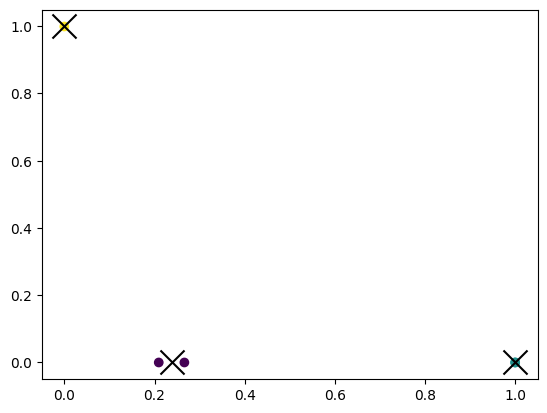

In [49]:
centre = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(matrice[:, 0], matrice[:, 1], c=labels)
plt.scatter(centre[:,0], centre[:,1], s = 300, marker = 'x', c = 'k')
plt.show()